In [95]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryFile
import random
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.


# Import Midi files to list
Working_Directory = os.getcwd()
Music_Directory = Working_Directory + "/Midi_Files/Piano_Midi/"
print(Working_Directory)
Midi_Directories = ["albeniz", "beeth", "borodin", "brahms", "burgm", "Chopin", "debussy", "granados", "grieg", "haydn", "liszt", "mendelssohn", "mozart", "muss", "schubert", "schumann", "tschai"]
max_time_steps = 256 # only files atleast this many 16th note steps are saved
num_validation_pieces=10


# Gather the training pieces from the specified directories
training_pieces={}
for f in range(len(Midi_Directories)):
    Training_Midi_Folder = Music_Directory + Midi_Directories[f]
    training_pieces = {**training_pieces, **multi_training.loadPieces(Training_Midi_Folder, max_time_steps)}

# Set aside a random set of pieces for validation purposes
validation_pieces={}
for v in range(num_validation_pieces):
    index = random.choice(list(training_pieces.keys()))
    validation_pieces[index] = training_pieces.pop(index)
    
    
print('')
print('Number of training pieces = ', len(training_pieces))    
print('Number of validation pieces = ', len(validation_pieces))     
    
    

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
practice_batch_size = 15
practice_num_timesteps = 128

_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)






/home/ecbm4040/Music_Project/Generating_Music
Loaded alb_esp5
Loaded alb_esp2
Loaded appass_3
Loaded mond_1
Loaded beethoven_opus10_3
Loaded pathetique_3
Loaded waldstein_3
Loaded mond_3
Loaded beethoven_les_adieux_2
Loaded beethoven_opus22_4
Loaded waldstein_1
Loaded beethoven_hammerklavier_1
Loaded appass_2
Loaded beethoven_les_adieux_1
Loaded beethoven_opus22_1
Loaded beethoven_opus10_2
Loaded pathetique_1
Loaded beethoven_opus90_2
Loaded bor_ps7
Loaded bor_ps1
Loaded bor_ps5
Loaded brahms_opus1_1
Loaded brahms_opus1_2
Loaded br_rhap
Loaded burg_spinnerlied
Loaded burg_erwachen
Loaded burg_agitato
Loaded burg_gewitter
Loaded burg_trennung
Loaded burg_quelle
Loaded chpn-p23
Loaded chpn-p4
Loaded chpn_op35_4
Loaded chpn-p3
Loaded chpn-p14
Loaded chpn-p2
Loaded chpn_op25_e2
Loaded chpn_op25_e12
Loaded chpn-p16
Loaded chpn-p15
Loaded chpn_op25_e11
Loaded chpn_op25_e1
Loaded chpn_op27_1
Loaded chpn_op66
Loaded chpn_op35_3
Loaded chpn_op25_e4
Loaded chpn-p8
Loaded chpn_op35_1
Loaded DEB_P

In [100]:
# Build the Model Graph:
tf.reset_default_graph()
print('Building Graph...')
#Capture number of notes from sample
num_notes = sample_state.shape[1]

# Graph Input Placeholders
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
time_init = tf.placeholder(dtype=tf.int32, shape=())

#Generate expanded tensor from batch of note state matrices
# Essential the CNN 'window' of this network
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Expand shape = ', Note_State_Expand.get_shape())


# lSTM Time Wise Training Graph 
num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)

print('Time-wise output shape = ', timewise_out.get_shape())




#LSTM Note Wise Graph

num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)

p_out = tf.sigmoid(y_out)
print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())



# Loss Function and Optimizer

loss, log_likelihood = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)

print('Graph Building Complete')



Building Graph...
Note_State_Expand shape =  (?, 78, ?, 80)
Time-wise output shape =  (?, 78, ?, 200)
y_out shape =  (?, 78, ?, 2)
generated samples shape =  (?, 78, ?, 2)
Graph Building Complete


creating new destination folder
destination folder exists
Load the model from: Latest
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Latest/Latest


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Latest/Latest


Obtaining new batch of pieces
epoch =  0  /  10000 :
Training loss =  0.114359 ; Training log likelihood =  -8.91997
Validation loss =  0.101436 ; Validation log likelihood =  -7.91198
epoch =  100  /  10000 :
Training loss =  0.0809658 ; Training log likelihood =  -6.31533
Validation loss =  0.111985 ; Validation log likelihood =  -8.73484
epoch =  200  /  10000 :
Training loss =  0.076271 ; Training log likelihood =  -5.94914
Validation loss =  0.115503 ; Validation log likelihood =  -9.00926
epoch =  300  /  10000 :
Training loss =  0.0712484 ; Training log likelihood =  -5.55738
Validation loss =  0.1224 ; Validation log likelihood =  -9.54719
epoch =  400  /  10000 :
Training loss =  0.069741 ; Training log likelihood =  -5.4398
Validation loss =  0.113256 ; Validation log likelihood =  -8.83394
Obtaining new batch of pieces
epoch =  500  /  10000 :
Training loss =  0.0853409 ; Training log likelihood =  -6.65659
Validation loss =  0.113216 ; Validation log likelihood =  -8.83081


epoch =  4800  /  10000 :
Training loss =  0.0687909 ; Training log likelihood =  -5.36569
Validation loss =  0.0971785 ; Validation log likelihood =  -7.57992
epoch =  4900  /  10000 :
Training loss =  0.0660225 ; Training log likelihood =  -5.14976
Validation loss =  0.0894038 ; Validation log likelihood =  -6.97349
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2
epoch =  5000  /  10000 :
Training loss =  0.0862149 ; Training log likelihood =  -6.72476
Validation loss =  0.0931936 ; Validation log likelihood =  -7.2691
epoch =  5100  /  10000 :
Training loss =  0.0642487 ; Training log likelihood =  -5.0114
Validation loss =  0.102285 ; Validation log likelihood =  -7.97823
epoch =  5200  /  10000 :
Training loss =  0.0605179 ; Training log likelihood =  -4.72039
Validation loss =  0.0970385 ; Validation log likelihood =  -7.569
epoch =  5300  /  10000 :
Training loss =  0.0591594 ; Training log likelihoo

Obtaining new batch of pieces
epoch =  9500  /  10000 :
Training loss =  0.0901046 ; Training log likelihood =  -7.02816
Validation loss =  0.098085 ; Validation log likelihood =  -7.65063
epoch =  9600  /  10000 :
Training loss =  0.0634349 ; Training log likelihood =  -4.94793
Validation loss =  0.0927966 ; Validation log likelihood =  -7.23814
epoch =  9700  /  10000 :
Training loss =  0.0607062 ; Training log likelihood =  -4.73509
Validation loss =  0.0909719 ; Validation log likelihood =  -7.09581
epoch =  9800  /  10000 :
Training loss =  0.0579558 ; Training log likelihood =  -4.52055
Validation loss =  0.100016 ; Validation log likelihood =  -7.80124
epoch =  9900  /  10000 :
Training loss =  0.0564614 ; Training log likelihood =  -4.40399
Validation loss =  0.118001 ; Validation log likelihood =  -9.20407
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2
epoch =  10000  /  10000 :
Training loss =  0

<function matplotlib.pyplot.show>

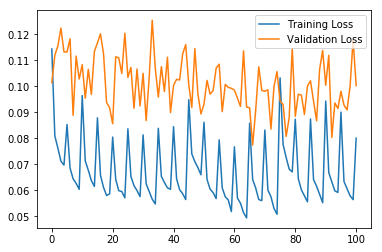

In [105]:
start_time = time.time()

# Training
N_epochs = 10000
loss_hist=[]
loss_valid_hist=[]
restore_model_name = 'Latest'
save_model_name = 'Piano_Midi2'
batch_size = 10
num_timesteps = 128
keep_prob=.5

Load_Directory = Working_Directory + "/Output/" + restore_model_name
Output_Directory = Working_Directory + "/Output/" + save_model_name

directory = os.path.dirname(Load_Directory)

try:
    print('creating new destination folder')
    os.mkdir(directory)    
except:
    print('destination folder exists')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, Load_Directory + '/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        # Generate random batch of training data        
        if (epoch % 500 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
       

        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        loss_run, log_likelihood_run, _, note_gen_out_run = sess.run([loss, log_likelihood, optimizer, note_gen_out], feed_dict=feed_dict)

        
        # Periodically save model and loss histories
        if (epoch % 1000 == 0) & (epoch > 0):
            save_path = saver.save(sess, Output_Directory + '/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            np.save(Output_Directory + "/ training_loss.npy", loss_hist)
            np.save(Output_Directory + "/ valid_loss.npy", loss_valid)
        
        # Regularly Calculate Validation loss and store both training and validation losses
        if (epoch % 100) == 0 & (epoch > 0):
            # Calculation Validation loss
            _, batch_input_state_valid = multi_training.getPieceBatch(validation_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state_valid = np.array(batch_input_state_valid)
            batch_input_state_valid = np.swapaxes(batch_input_state_valid, axis1=1, axis2=2)    
            feed_dict = {Note_State_Batch: batch_input_state_valid, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
            loss_valid, log_likelihood_valid = sess.run([loss, log_likelihood], feed_dict=feed_dict)
            
            print('epoch = ', epoch, ' / ', N_epochs, ':')
            print('Training loss = ', loss_run, '; Training log likelihood = ', log_likelihood_run)
            print('Validation loss = ', loss_valid, '; Validation log likelihood = ', log_likelihood_valid)
            
            loss_hist.append(loss_run)
            loss_valid_hist.append(loss_valid)
        
        # Periodically generate Sample of music
            

end_time = time.time()

print('Training time = ', end_time - start_time, ' seconds')

# Plot the loss histories
plt.plot(loss_hist, label="Training Loss")
plt.plot(loss_valid_hist, label="Validation Loss")
plt.legend()
plt.show

In [106]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files

epoch = epoch
#Load Model
load_model_name = save_model_name

Load_Directory = Working_Directory + "/Output/" + load_model_name
directory = os.path.dirname(Load_Directory)



try:
    os.mkdir(directory)       
except:
    print('directory exists')
    
    
#Length of generated music
T_gen = 16*16
batch_gen_size = 5
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(load_model_name))
    saver.restore(sess, Load_Directory + '/{}'.format(load_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    


        
# Save Generate Notes to .MIDI file
notes_gen_out = np.stack(notes_gen_arr, axis=2)
notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
    
for iter in range(batch_gen_size):
    file = Load_Directory + "/Epoch " + str(epoch) + " Music" + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)
    
print('Midi files saved')   
    
    

directory exists
Load the model from: Piano_Midi2
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
Midi files saved
